In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import warnings; warnings.filterwarnings('ignore') #matplot lib complains about librosa

In [ ]:
#google colab has an old version of librosa with missing mel spectrogram args (for MFCC); upgrade to current
!pip install -U librosa 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# needed to import dataset from google drive into colab 
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# copy RAVDESS dataset from gdrive and unzip
!cp '/content/gdrive/MyDrive/machine learning datasets/ravdess.zip' .
!unzip -q ravdess.zip 

In [ ]:
import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/machine learning datasets/ravdess.zip', 'r') as zip_ref:
    zip_ref.extractall(path='./data')

In [ ]:
# RAVDESS native sample rate is 48k
sample_rate = 48000


def feature_mfcc(
    waveform, 
    sample_rate,
    n_mfcc = 40,
    fft = 1024,
    winlen = 512,
    window='hamming',
    mels=128
    ):


    mfc_coefficients=librosa.feature.mfcc(
        y=waveform, 
        sr=sample_rate, 
        n_mfcc=n_mfcc,
        n_fft=fft, 
        win_length=winlen, 
        window=window, 
        #hop_length=hop, 
        n_mels=mels, 
        fmax=sample_rate/2
        ) 

    return mfc_coefficients

def get_features(waveforms, features, samplerate):


    file_count = 0
    for waveform in waveforms:
        mfccs = feature_mfcc(waveform, sample_rate)
        features.append(mfccs)
        file_count += 1
        # print progress 
        print('\r'+f' Processed {file_count}/{len(waveforms)} waveforms',end='')
    return features

def get_waveforms(file):
    
    waveform, _ = librosa.load(file, duration=3, offset=0.5, sr=sample_rate)
    waveform_homo = np.zeros((int(sample_rate*3,)))
    waveform_homo[:len(waveform)] = waveform                                 
    return waveform_homo
    

emotions_dict ={
    '0':'surprised',
    '1':'neutral',
    '2':'calm',
    '3':'happy',
    '4':'sad',
    '5':'angry',
    '6':'fearful',
    '7':'disgust'
}


emotion_attributes = {
    '01': 'normal',
    '02': 'strong'
}

## Load Data and Extract Features



In [ ]:

data_path = './Actor_*/*.wav'

def load_data():
    
    emotions = []
    waveforms = []
    intensities, genders = [],[]
    # progress counter
    file_count = 0
    for file in glob.glob(data_path):
        # get file name with labels
        file_name = os.path.basename(file)
        
        # get emotion label from the sample's file
        emotion = int(file_name.split("-")[2])

        #  move surprise to 0 for cleaner behaviour with PyTorch/0-indexing
        if emotion == 8: emotion = 0 

        # can convert emotion label to emotion string if desired, but
        
        # get other labels we might want
        intensity = emotion_attributes[file_name.split("-")[3]]
        # even actors are female, odd are male
        if (int((file_name.split("-")[6]).split(".")[0]))%2==0: 
            gender = 'female' 
        else: 
            gender = 'male'
            
        # get waveform from the sample
        waveform = get_waveforms(file)
        
        # store waveforms and labels
        waveforms.append(waveform)
        emotions.append(emotion)
        intensities.append(intensity) 
        genders.append(gender) 
        
        file_count += 1
        # keep track of data loader's progress
        print('\r'+f' Processed {file_count}/{1440} audio samples',end='')
        
    return waveforms, emotions, intensities, genders

In [ ]:
# load data 
waveforms, emotions, intensities, genders = [],[],[],[]
waveforms, emotions, intensities, genders = load_data()

 Processed 1440/1440 audio samples

## Check extracted audio waveforms and labels:


In [ ]:
print(f'Waveforms set: {len(waveforms)} samples')
# we have 1440 waveforms but we need to know their length too; should be 3 sec * 48k = 144k
print(f'Waveform signal length: {len(waveforms[0])}')
print(f'Emotions set: {len(emotions)} sample labels')

Waveforms set: 1440 samples
Waveform signal length: 144000
Emotions set: 1440 sample labels


In [ ]:
# create storage for train, validation, test sets and their indices
train_set,valid_set,test_set = [],[],[]
X_train,X_valid,X_test = [],[],[]
y_train,y_valid,y_test = [],[],[]

# convert waveforms to array for processing
waveforms = np.array(waveforms)

# process each emotion separately to make sure we builf balanced train/valid/test sets 
for emotion_num in range(len(emotions_dict)):
        
    # find all indices of a single unique emotion
    emotion_indices = [index for index, emotion in enumerate(emotions) if emotion==emotion_num]

    # seed for reproducibility 
    np.random.seed(69)
    # shuffle indicies 
    emotion_indices = np.random.permutation(emotion_indices)

    # store dim (length) of the emotion list to make indices
    dim = len(emotion_indices)

    # store indices of training, validation and test sets in 80/10/10 proportion
    # train set is first 80%
    train_indices = emotion_indices[:int(0.8*dim)]
    # validation set is next 10% (between 80% and 90%)
    valid_indices = emotion_indices[int(0.8*dim):int(0.9*dim)]
    # test set is last 10% (between 90% - end/100%)
    test_indices = emotion_indices[int(0.9*dim):]

    # create train waveforms/labels sets
    X_train.append(waveforms[train_indices,:])
    y_train.append(np.array([emotion_num]*len(train_indices),dtype=np.int32))
    # create validation waveforms/labels sets
    X_valid.append(waveforms[valid_indices,:])
    y_valid.append(np.array([emotion_num]*len(valid_indices),dtype=np.int32))
    # create test waveforms/labels sets
    X_test.append(waveforms[test_indices,:])
    y_test.append(np.array([emotion_num]*len(test_indices),dtype=np.int32))

    # store indices for each emotion set to verify uniqueness between sets 
    train_set.append(train_indices)
    valid_set.append(valid_indices)
    test_set.append(test_indices)

# concatenate, in order, all waveforms back into one array 
X_train = np.concatenate(X_train,axis=0)
X_valid = np.concatenate(X_valid,axis=0)
X_test = np.concatenate(X_test,axis=0)

# concatenate, in order, all emotions back into one array 
y_train = np.concatenate(y_train,axis=0)
y_valid = np.concatenate(y_valid,axis=0)
y_test = np.concatenate(y_test,axis=0)

# combine and store indices for all emotions' train, validation, test sets to verify uniqueness of sets
train_set = np.concatenate(train_set,axis=0)
valid_set = np.concatenate(valid_set,axis=0)
test_set = np.concatenate(test_set,axis=0)

# check shape of each set
print(f'Training waveforms:{X_train.shape}, y_train:{y_train.shape}')
print(f'Validation waveforms:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'Test waveforms:{X_test.shape}, y_test:{y_test.shape}')

# make sure train, validation, test sets have no overlap/are unique
uniques, count = np.unique(np.concatenate([train_set,test_set,valid_set],axis=0), return_counts=True)

# if each index appears just once, and we have 1440 such unique indices, then all sets are unique
if sum(count==1) == len(emotions):
    print(f'\nSets are unique: {sum(count==1)} samples out of {len(emotions)} are unique')
else:
    print(f'\nSets are NOT unique: {sum(count==1)} samples out of {len(emotions)} are unique')    

Training waveforms:(1147, 144000), y_train:(1147,)
Validation waveforms:(143, 144000), y_valid:(143,)
Test waveforms:(150, 144000), y_test:(150,)

Sets are unique: 1440 samples out of 1440 are unique


## Extract Features 


In [ ]:
# initialize feature arrays
features_train, features_valid, features_test = [],[],[]

print('Train waveforms:') # get training set features 
features_train = get_features(X_train, features_train, sample_rate)

print('\n\nValidation waveforms:') # get validation set features
features_valid = get_features(X_valid, features_valid, sample_rate)

print('\n\nTest waveforms:') # get test set features 
features_test = get_features(X_test, features_test, sample_rate)

print(f'\n\nFeatures set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'Features (MFC coefficient matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
 Processed 1147/1147 waveforms

Validation waveforms:
 Processed 143/143 waveforms

Test waveforms:
 Processed 150/150 waveforms

Features set: 1440 total, 1147 train, 143 validation, 150 test samples
Features (MFC coefficient matrix) shape: 40 mel frequency coefficients x 282 time steps


## Augmenting the Data with AWGN - Additive White Gaussian Noise

In [ ]:
def awgn_augmentation(waveform, multiples=2, bits=16, snr_min=15, snr_max=30): 
    
    # get length of waveform (should be 3*48k = 144k)
    wave_len = len(waveform)
    
    # Generate normally distributed (Gaussian) noises
    noise = np.random.normal(size=(multiples, wave_len))
    
    # Normalize waveform and noise
    norm_constant = 2.0**(bits-1)
    norm_wave = waveform / norm_constant
    norm_noise = noise / norm_constant
    
    # Compute power of waveform and power of noise
    signal_power = np.sum(norm_wave ** 2) / wave_len
    noise_power = np.sum(norm_noise ** 2, axis=1) / wave_len
    
    # Choose random SNR in decibels in range [15,30]
    snr = np.random.randint(snr_min, snr_max)
    
   
    covariance = np.sqrt((signal_power / noise_power) * 10 ** (- snr / 10))
 
    covariance = np.ones((wave_len, multiples)) * covariance

    multiple_augmented_waveforms = waveform + covariance.T * noise
    
    return multiple_augmented_waveforms

In [ ]:
def augment_waveforms(waveforms, features, emotions, multiples):
    emotion_count = 0
    added_count = 0
    emotions = emotions.tolist()

    for waveform in waveforms:

        # Generate 2 augmented multiples of the dataset
        augmented_waveforms = awgn_augmentation(waveform, multiples=multiples)

      
        for augmented_waveform in augmented_waveforms:

            # find MFCCs over augmented waveforms
            augmented_mfcc = feature_mfcc(augmented_waveform, sample_rate=sample_rate)

            # append the augmented spectrogram 
            features.append(augmented_mfcc)
            emotions.append(emotions[emotion_count])

            # count of new augmented samples
            added_count += 1

            # check progress
            print('\r'+f'Processed {emotion_count + 1}/{len(waveforms)} waveforms for {added_count}/{len(waveforms)*multiples} new augmented samples',end='')

        emotion_count += 1
        augmented_waveforms_temp.append(augmented_waveforms)
    
    return features, emotions

### Compute AWGN-augmented features and add to the rest of the dataset



In [ ]:
# store augmented waveforms to verify their shape and random-ness
augmented_waveforms_temp = []

# specify multiples of our dataset to add as augmented data
multiples = 2

print('Train waveforms:') # augment waveforms of training set
features_train , y_train = augment_waveforms(X_train, features_train, y_train, multiples)

print('\n\nValidation waveforms:') # augment waveforms of validation set
features_valid, y_valid = augment_waveforms(X_valid, features_valid, y_valid, multiples)

print('\n\nTest waveforms:') # augment waveforms of test set 
features_test, y_test = augment_waveforms(X_test, features_test, y_test, multiples)

# Check new shape of extracted features and data:
print(f'\n\nNative + Augmented Features set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'{len(y_train)} training sample labels, {len(y_valid)} validation sample labels, {len(y_test)} test sample labels')
print(f'Features (MFCC matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
Processed 1147/1147 waveforms for 2294/2294 new augmented samples

Validation waveforms:
Processed 143/143 waveforms for 286/286 new augmented samples

Test waveforms:
Processed 150/150 waveforms for 300/300 new augmented samples

Native + Augmented Features set: 4320 total, 3441 train, 429 validation, 450 test samples
3441 training sample labels, 429 validation sample labels, 450 test sample labels
Features (MFCC matrix) shape: 40 mel frequency coefficients x 282 time steps


### Check Augmented Waveforms:

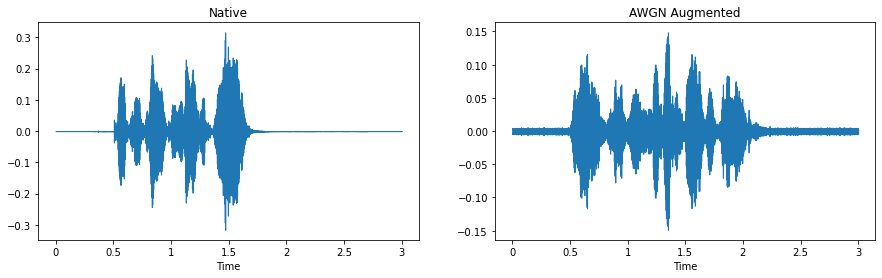

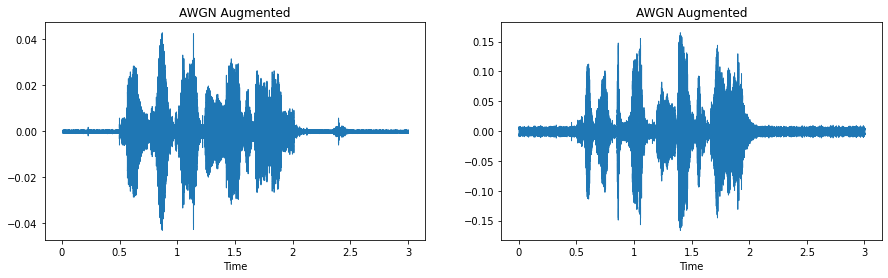

In [ ]:
# pick a random waveform, but same one from native and augmented set for easier comparison
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveshow(waveforms[12], sr=sample_rate)
plt.title('Native')

plt.subplot(1, 2, 2)
# augmented waveforms are 2D len 1440 list with 2 waveforms in each position
librosa.display.waveshow(augmented_waveforms_temp[0][0], sr=sample_rate)
plt.title('AWGN Augmented')
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveshow(augmented_waveforms_temp[2][0], sr=sample_rate)
plt.title('AWGN Augmented')

plt.subplot(1, 2, 2)
librosa.display.waveshow(augmented_waveforms_temp[7][0], sr=sample_rate)
plt.title('AWGN Augmented')
plt.show()



## Format Data into Tensor Ready 4D Arrays


In [ ]:
X_train = np.expand_dims(features_train,1)
X_valid = np.expand_dims(features_valid, 1)
X_test = np.expand_dims(features_test,1)


y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)


print(f'Shape of 4D feature array for input tensor: {X_train.shape} train, {X_valid.shape} validation, {X_test.shape} test')
print(f'Shape of emotion labels: {y_train.shape} train, {y_valid.shape} validation, {y_test.shape} test')

Shape of 4D feature array for input tensor: (3441, 1, 40, 282) train, (429, 1, 40, 282) validation, (450, 1, 40, 282) test
Shape of emotion labels: (3441,) train, (429,) validation, (450,) test


In [ ]:
# free up some RAM - no longer need full feature set or any waveforms 
del features_train, features_valid, features_test, waveforms, augmented_waveforms_temp

## Feature Scaling



In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
 
N,C,H,W = X_train.shape

X_train = np.reshape(X_train, (N,-1)) 
X_train = scaler.fit_transform(X_train)

X_train = np.reshape(X_train, (N,C,H,W))


N,C,H,W = X_valid.shape
X_valid = np.reshape(X_valid, (N,-1))
X_valid = scaler.transform(X_valid)
X_valid = np.reshape(X_valid, (N,C,H,W))


N,C,H,W = X_test.shape
X_test = np.reshape(X_test, (N,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (N,C,H,W))

# check shape of each set again
print(f'X_train scaled:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_valid scaled:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test scaled:{X_test.shape}, y_test:{y_test.shape}')

X_train scaled:(3441, 1, 40, 282), y_train:(3441,)
X_valid scaled:(429, 1, 40, 282), y_valid:(429,)
X_test scaled:(450, 1, 40, 282), y_test:(450,)


##Reload Data as NumPy Arrays 


In [ ]:

filename = 'features+labels.npy'

# open file in write mode and write data
with open(filename, 'wb') as f:
    np.save(f, X_train)
    np.save(f, X_valid)
    np.save(f, X_test)
    np.save(f, y_train)
    np.save(f, y_valid)
    np.save(f, y_test)

print(f'Features and labels saved to {filename}')

Features and labels saved to features+labels.npy


In [ ]:

filename = 'features+labels.npy'

# open file in read mode and read data 
with open(filename, 'rb') as f:
    X_train = np.load(f)
    X_valid = np.load(f)
    X_test = np.load(f)
    y_train = np.load(f)
    y_valid = np.load(f)
    y_test = np.load(f)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test:{X_test.shape}, y_test:{y_test.shape}') 

X_train:(3441, 1, 40, 282), y_train:(3441,)
X_valid:(429, 1, 40, 282), y_valid:(429,)
X_test:(450, 1, 40, 282), y_test:(450,)


# Architecture Overview
<img src="https://github.com/IliaZenkov/transformer-cnn-emotion-recognition/blob/main/notebooks/reports/cnn-transformer-final.png?raw=1">


# Build Model Architectures

In [ ]:
!pip install pathos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 
     |████████████████████████████████| 115 kB 33.8 MB/s 


In [ ]:
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import as_completed
values = [2,3,4,5]
def square(n):
   return n * n
def main():
   with ProcessPoolExecutor(max_workers = 3) as executor:
      results = executor.map(square, values)
   for result in results:
      print(result)
if __name__ == '__main__':
   main()

4
9
16
25


In [ ]:
import threading
from pathos.multiprocessing import ProcessingPool as Pool

##Model 1: 1 CNN without parallelisation

In [ ]:
#change nn.sequential to take dict to make more readable 

class cnn_model(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
        
        #CNN block 1
        self.conv2Dblock1 = nn.Sequential(
            
            #convolution layer
            nn.Conv2d(
                in_channels=1, 
                out_channels=16, 
                kernel_size=3, 
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=16, 
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), 
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=32,
                out_channels=64, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        

      
        #linear block
        self.fc1_linear = nn.Linear(512,num_emotions) 
        self.softmax_out = nn.Softmax(dim=1)
        
    
    def forward(self,x):
        

        conv2d_embedding1 = self.conv2Dblock1(x)
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
        
        
        #final embedding 
        complete_embedding = torch.cat([conv2d_embedding1], dim=1)  

        #Get vector of 8 with probabilities
        output_logits = self.fc1_linear(complete_embedding)  
        output_softmax = self.softmax_out(output_logits)
        
        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax                       

##Model 2: 2 CNNS in parallel

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
from multiprocessing import Process

In [ ]:
'''
        with ThreadPoolExecutor as executor:
          conv2d_embedding1 = executor.map(self.conv2Dblock1, x)
          #conv2d_embedding2 = executor.map(self.conv2Dblock2, x)
        for result in conv2d_embedding1:
          print(result)
        '''
'''
  manager = multiprocessing.Manager()
        conv2d_embedding1  = manager.list()
        conv2d_embedding2  = manager.list()
        p1=Process(target=self.conv1,args=(x,conv2d_embedding1))
        p1.start()
        p2=Process(target=self.conv2,args=(x,conv2d_embedding2))
        p2.start()
        p1.join()
        p2.join()
        device = 'cuda'
        conv2d_embedding1 = torch.Tensor(conv2d_embedding1)
        conv2d_embedding2 = torch.Tensor(conv2d_embedding2)
        conv2d_embedding1 = conv2d_embedding1.to(device)
        conv2d_embedding2 = conv2d_embedding2.to(device)
      '''

In [ ]:
#change nn.sequential to take dict to make more readable 

class parallel_model_2cnn(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
        #1st CNN
        #CNN block 1
        self.conv2Dblock1 = nn.Sequential(
            
            #convolution layer
            nn.Conv2d(
                in_channels=1, 
                out_channels=16, 
                kernel_size=3, 
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=16, 
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), 
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=32,
                out_channels=64, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        
        #2nd CNN
        #CNN block 2
        self.conv2Dblock2 = nn.Sequential(
            
            #convolution layer
            nn.Conv2d(
                in_channels=1, 
                out_channels=16, 
                kernel_size=3, 
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(p=0.3), 
            
           #convolution layer
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=32,
                out_channels=64, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )

      
        #linear block
        self.fc1_linear = nn.Linear(512*2,num_emotions) 
        self.softmax_out = nn.Softmax(dim=1)
    def conv1(self, x, conv2d_embedding1):
      conv2d_embedding1 = self.conv2Dblock1(x)
    def conv2(self, x, conv2d_embedding2):
      conv2d_embedding2 = self.conv2Dblock2(x)
    
    def forward(self,x):
        
        #parallel cnns
        conv2d_embedding1 = self.conv2Dblock1(x)
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
        
       
        conv2d_embedding2 = self.conv2Dblock2(x)
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 
        
        
        #final embedding 
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2], dim=1)  

        #Get vector of 8 with probabilities
        output_logits = self.fc1_linear(complete_embedding)  
        output_softmax = self.softmax_out(output_logits)
        
        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax                       

##Model 3: 4 CNNS in parallel

In [ ]:
#change nn.sequential to take dict to make more readable 

class parallel_model_4cnn(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
        #1st CNN
        #CNN block 1
        self.conv2Dblock1 = nn.Sequential(
            
            #convolution layer
            nn.Conv2d(
                in_channels=1, 
                out_channels=16, 
                kernel_size=3, 
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=16, 
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), 
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=32,
                out_channels=64, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        
        #2nd CNN
        #CNN block 2
        self.conv2Dblock2 = nn.Sequential(
            
            #convolution layer
            nn.Conv2d(
                in_channels=1, 
                out_channels=16, 
                kernel_size=3, 
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(p=0.3), 
            
           #convolution layer
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=32,
                out_channels=64, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )

        self.conv2Dblock3 = nn.Sequential(
            
            #convolution layer
            nn.Conv2d(
                in_channels=1, 
                out_channels=16, 
                kernel_size=3, 
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(p=0.3), 
            
           #convolution layer
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=32,
                out_channels=64, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )

        self.conv2Dblock4 = nn.Sequential(
            
            #convolution layer
            nn.Conv2d(
                in_channels=1, 
                out_channels=16, 
                kernel_size=3, 
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(p=0.3), 
            
           #convolution layer
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=32,
                out_channels=64, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
      
        #linear block
        self.fc1_linear = nn.Linear(512*4,num_emotions) 
        self.softmax_out = nn.Softmax(dim=1)
        
    
    def forward(self,x):
        
        #parallel cnns
        conv2d_embedding1 = self.conv2Dblock1(x)
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
        
       
        conv2d_embedding2 = self.conv2Dblock2(x)
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 
        
        conv2d_embedding3 = self.conv2Dblock3(x)
        conv2d_embedding3 = torch.flatten(conv2d_embedding3, start_dim=1) 

        conv2d_embedding4 = self.conv2Dblock4(x)
        conv2d_embedding4 = torch.flatten(conv2d_embedding4, start_dim=1) 
        
        #final embedding 
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2, conv2d_embedding3, conv2d_embedding4], dim=1)  

        #Get vector of 8 with probabilities
        output_logits = self.fc1_linear(complete_embedding)  
        output_softmax = self.softmax_out(output_logits)
        
        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax                       

##Model 4: 2 CNNS and a transformer encoder in parallel

In [ ]:
#change nn.sequential to take dict to make more readable 

class parallel_model(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
       #transformer
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4]) #40*70
        
        # define single transformer encoder layer
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=40, 
            nhead=4, 
            dim_feedforward=512, 
            dropout=0.4, 
            activation='relu' 
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)
        
        #1st CNN
        #CNN block 1
        #(1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)
        self.conv2Dblock1 = nn.Sequential(
            
            #convolution layer
            nn.Conv2d(
                in_channels=1, 
                out_channels=16, 
                kernel_size=3, 
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=16, 
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), 
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=32,
                out_channels=64, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        
        #2nd CNN
        #CNN block 2
        self.conv2Dblock2 = nn.Sequential(
            
            #convolution layer
            nn.Conv2d(
                in_channels=1, 
                out_channels=16, 
                kernel_size=3, 
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(p=0.3), 
            
           #convolution layer
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3), 
            
            #convolution layer
            nn.Conv2d(
                in_channels=32,
                out_channels=64, 
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )

      
        #linear block
        self.fc1_linear = nn.Linear(512*2+40,num_emotions) 
        self.softmax_out = nn.Softmax(dim=1)
        
    
    def forward(self,x):
        
        #parallel cnns
        conv2d_embedding1 = self.conv2Dblock1(x)
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
        
       
        conv2d_embedding2 = self.conv2Dblock2(x)
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 
        
        #transformer
        x_maxpool = self.transformer_maxpool(x)
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        x = x_maxpool_reduced.permute(2,0,1) 
        transformer_output = self.transformer_encoder(x)
        transformer_embedding = torch.mean(transformer_output, dim=0)
        
        #final embedding 
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2,transformer_embedding], dim=1)  

        #Get vector of 8 with probabilities
        output_logits = self.fc1_linear(complete_embedding)  
        output_softmax = self.softmax_out(output_logits)
        
        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax                       

Model


In [ ]:
device = 'cuda'
model = parallel_model(len(emotions_dict)).to(device)
model.eval()

parallel_model(
  (transformer_maxpool): MaxPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0, dilation=1, ceil_mode=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=40, out_features=40, bias=True)
        )
        (linear1): Linear(in_features=40, out_features=512, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=512, out_features=40, bias=True)
        (norm1): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=40, out_features=40, bias=True)
    

##Loss/Criterion

In [ ]:
def criterion(predictions, targets): 
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

In [ ]:
#Choose a model

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

#model = cnn_model(num_emotions=len(emotions_dict)).to(device)
model = parallel_model_2cnn(num_emotions=len(emotions_dict)).to(device) 
#model = parallel_model_4cnn(num_emotions=len(emotions_dict)).to(device) 
#model = parallel_model(num_emotions=len(emotions_dict)).to(device)

cuda selected


In [ ]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

## Define Training Step




In [ ]:
# define function to create a single step of the training phase
def make_train_step(model, criterion, optimizer):
    
    # define the training step of the training phase
    def train_step(X,Y):
        
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        
        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y) 
        
        # compute gradients for the optimizer to use 
        loss.backward()
        
        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()
        
        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad() 
        
        return loss.item(), accuracy*100
    return train_step

## Define Validation Step

In [ ]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):
        
        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase: 
        with torch.no_grad(): 
            
            # set model to validation phase i.e. turn off dropout and batchnorm layers 
            model.eval()
      
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            
            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100, predictions
    return validate

# Make Checkpoint Functions


In [ ]:
def make_save_checkpoint(): 
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

# Build Training Loop



In [ ]:
# get training set size to calculate # iterations and minibatch indices
train_size = X_train.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

#Choose a model
#model = cnn_model(num_emotions=len(emotions_dict)).to(device)
model = parallel_model_2cnn(num_emotions=len(emotions_dict)).to(device) 
#model = parallel_model_4cnn(num_emotions=len(emotions_dict)).to(device) 
#model = parallel_model(num_emotions=len(emotions_dict)).to(device) 

 

print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )


optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

save_checkpoint = make_save_checkpoint()


train_step = make_train_step(model, criterion, optimizer=optimizer)


validate = make_validate_fnc(model,criterion)


train_losses=[]
valid_losses = []
train_acc = []
valid_accu = []


def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):

    for epoch in range(num_epochs):
        
        model.train()         
        train_indices = np.random.permutation(train_size) 
        X_train = X_train[train_indices,:,:,:] 
        Y_train = Y_train[train_indices]

        epoch_acc = 0 
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)
        

        for i in range(num_iterations):

            batch_start = i * minibatch 

            batch_end = min(batch_start + minibatch, train_size) 
            actual_batch_size = batch_end-batch_start 
            
            X = X_train[batch_start:batch_end,:,:,:] 
            Y = Y_train[batch_start:batch_end] 

            X_tensor = torch.tensor(X, device=device).float() 
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
            
            loss, acc = train_step(X_tensor,Y_tensor) 

            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size

            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}',end='')
        

        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)
        

        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)

        train_acc.append(epoch_acc)
        valid_accu.append(valid_acc)
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
                  

        checkpoint_filename = '/content/gdrive/MyDrive/models/checkpoints/audioparallel-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        

        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')


cuda selected
Number of trainable params:  55240


## Train Model

###Model 1 - 1 CNN

In [ ]:
num_epochs = 100
model = cnn_model(num_emotions=len(emotions_dict)).to(device) 
train(optimizer, model, num_epochs, X_train, y_train, X_valid, y_valid)

In [ ]:
train_losses1 = train_losses
valid_losses1  = valid_losses
train_acc1 = torch.tensor(train_acc,device='cpu').float()
valid_accu1 = torch.tensor(valid_accu,device='cpu').float()

#re-instantiate lists
train_losses=[]
valid_losses = []
train_acc = []
valid_accu = []

###Model 2 - 2 CNNS


In [ ]:
num_epochs = 100
train(optimizer, model, num_epochs, X_train, y_train, X_valid, y_valid)

Epoch 0: iteration 106/107
Epoch 0 --- loss:3.166, Epoch accuracy:23.54%, Validation loss:2.071, Validation accuracy:22.14%
Epoch 1: iteration 106/107
Epoch 1 --- loss:1.821, Epoch accuracy:31.27%, Validation loss:1.820, Validation accuracy:28.67%
Epoch 2: iteration 106/107
Epoch 2 --- loss:1.701, Epoch accuracy:34.00%, Validation loss:1.797, Validation accuracy:31.70%
Epoch 3: iteration 106/107
Epoch 3 --- loss:1.604, Epoch accuracy:39.26%, Validation loss:1.679, Validation accuracy:39.63%
Epoch 4: iteration 106/107
Epoch 4 --- loss:1.497, Epoch accuracy:44.06%, Validation loss:1.625, Validation accuracy:40.09%
Epoch 5: iteration 106/107
Epoch 5 --- loss:1.419, Epoch accuracy:45.74%, Validation loss:1.338, Validation accuracy:51.98%
Epoch 6: iteration 106/107
Epoch 6 --- loss:1.314, Epoch accuracy:50.71%, Validation loss:1.300, Validation accuracy:45.92%
Epoch 7: iteration 106/107
Epoch 7 --- loss:1.289, Epoch accuracy:51.03%, Validation loss:1.296, Validation accuracy:51.28%
Epoch 8:

In [ ]:
train_losses2 = train_losses
valid_losses2  = valid_losses
train_acc2 = torch.tensor(train_acc,device='cpu').float()
valid_accu2 = torch.tensor(valid_accu,device='cpu').float()

#re-instantiate lists
train_losses=[]
valid_losses = []
train_acc = []
valid_accu = []

###Model 3 - 4 CNNS


In [ ]:
num_epochs = 100
train(optimizer, model, num_epochs, X_train, y_train, X_valid, y_valid)

Epoch 0: iteration 106/107
Epoch 0 --- loss:5.031, Epoch accuracy:22.52%, Validation loss:2.487, Validation accuracy:14.45%
Epoch 1: iteration 106/107
Epoch 1 --- loss:1.870, Epoch accuracy:32.32%, Validation loss:2.374, Validation accuracy:20.98%
Epoch 2: iteration 106/107
Epoch 2 --- loss:1.722, Epoch accuracy:37.69%, Validation loss:1.977, Validation accuracy:29.14%
Epoch 3: iteration 106/107
Epoch 3 --- loss:1.553, Epoch accuracy:42.31%, Validation loss:1.984, Validation accuracy:27.51%
Epoch 4: iteration 106/107
Epoch 4 --- loss:1.472, Epoch accuracy:45.10%, Validation loss:1.705, Validation accuracy:39.39%
Epoch 5: iteration 106/107
Epoch 5 --- loss:1.392, Epoch accuracy:47.78%, Validation loss:1.702, Validation accuracy:39.39%
Epoch 6: iteration 106/107
Epoch 6 --- loss:1.321, Epoch accuracy:51.67%, Validation loss:1.691, Validation accuracy:38.46%
Epoch 7: iteration 106/107
Epoch 7 --- loss:1.246, Epoch accuracy:54.03%, Validation loss:1.620, Validation accuracy:41.96%
Epoch 8:

In [ ]:
train_losses3 = train_losses
valid_losses3  = valid_losses
train_acc3 = torch.tensor(train_acc,device='cpu').float()
valid_accu3 = torch.tensor(valid_accu,device='cpu').float()

#re-instantiate lists
train_losses=[]
valid_losses = []
train_acc = []
valid_accu = []

###Model 4

In [ ]:
num_epochs = 100
#model = parallel_model(num_emotions=len(emotions_dict)).to(device) 

train(optimizer, model, num_epochs, X_train, y_train, X_valid, y_valid)

Epoch 0: iteration 106/107
Epoch 0 --- loss:3.119, Epoch accuracy:25.14%, Validation loss:2.155, Validation accuracy:27.97%
Epoch 1: iteration 106/107
Epoch 1 --- loss:1.646, Epoch accuracy:36.56%, Validation loss:1.841, Validation accuracy:29.37%
Epoch 2: iteration 106/107
Epoch 2 --- loss:1.543, Epoch accuracy:40.66%, Validation loss:1.657, Validation accuracy:44.99%
Epoch 3: iteration 106/107
Epoch 3 --- loss:1.434, Epoch accuracy:45.68%, Validation loss:1.445, Validation accuracy:46.85%
Epoch 4: iteration 106/107
Epoch 4 --- loss:1.361, Epoch accuracy:48.88%, Validation loss:1.374, Validation accuracy:49.18%
Epoch 5: iteration 106/107
Epoch 5 --- loss:1.256, Epoch accuracy:52.14%, Validation loss:1.275, Validation accuracy:57.11%
Epoch 6: iteration 106/107
Epoch 6 --- loss:1.205, Epoch accuracy:55.07%, Validation loss:1.238, Validation accuracy:55.71%
Epoch 7: iteration 106/107
Epoch 7 --- loss:1.134, Epoch accuracy:58.27%, Validation loss:1.092, Validation accuracy:60.37%
Epoch 8:

In [ ]:
train_losses4 = train_losses
valid_losses4  = valid_losses
train_acc4 = torch.tensor(train_acc,device='cpu').float()
valid_accu4 = torch.tensor(valid_accu,device='cpu').float()

#re-instantiate lists
train_losses=[]
valid_losses = []
train_acc = []
valid_accu = []

# Checking/Comparing the Loss and Accuracy Curve's Behaviour of the models

##Model 1 - 1 CNN

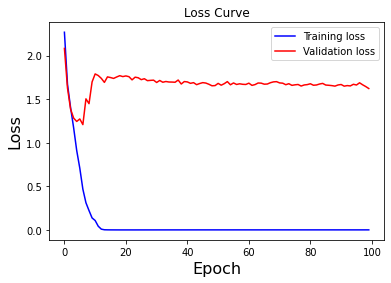

In [ ]:
plt.title('Loss Curve')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses1[:],'b')
plt.plot(valid_losses1[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

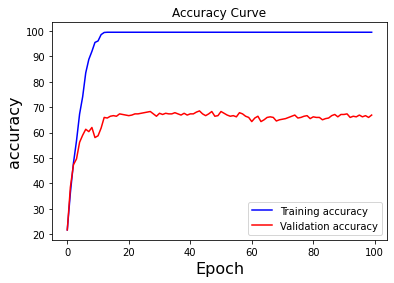

In [ ]:
plt.title('Accuracy Curve')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_acc1[:],'b')
plt.plot(valid_accu1[:],'r')
plt.legend(['Training accuracy','Validation accuracy'])
plt.show()

##Model 2 - 2 CNN's in parallel

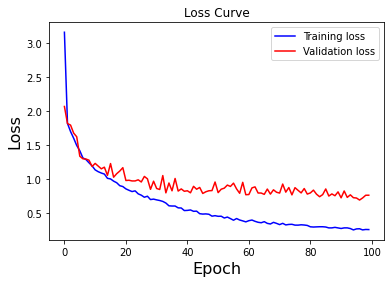

In [ ]:
plt.title('Loss Curve')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses2[:],'b')
plt.plot(valid_losses2[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

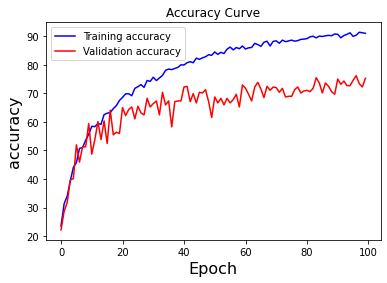

In [ ]:
plt.title('Accuracy Curve')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_acc2[:],'b')
plt.plot(valid_accu2[:],'r')
plt.legend(['Training accuracy','Validation accuracy'])
plt.show()

##Model 3 - 4 CNN's in parallel

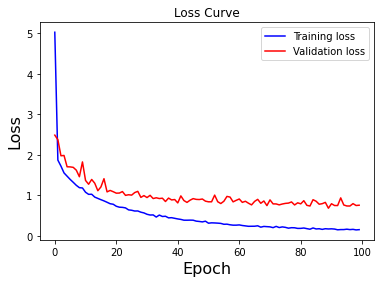

In [ ]:
plt.title('Loss Curve')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses3[:],'b')
plt.plot(valid_losses3[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

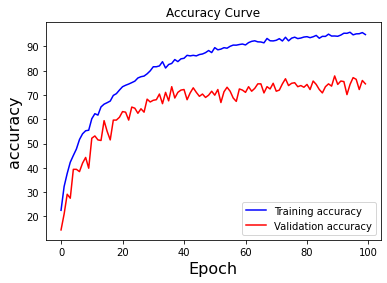

In [ ]:
plt.title('Accuracy Curve')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_acc3[:],'b')
plt.plot(valid_accu3[:],'r')
plt.legend(['Training accuracy','Validation accuracy'])
plt.show()

##Model 4 - 2 CNN's and a transformer-encoder in parallel

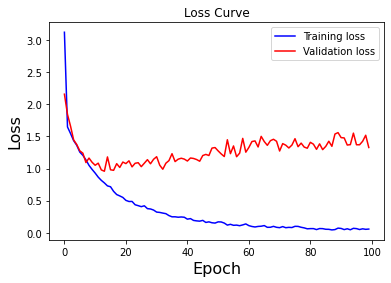

In [ ]:
plt.title('Loss Curve')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses4[:],'b')
plt.plot(valid_losses4[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

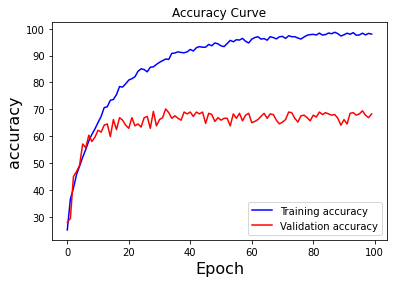

In [ ]:
plt.title('Accuracy Curve')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_acc4[:],'b')
plt.plot(valid_accu4[:],'r')
plt.legend(['Training accuracy','Validation accuracy'])
plt.show()

##Comparison

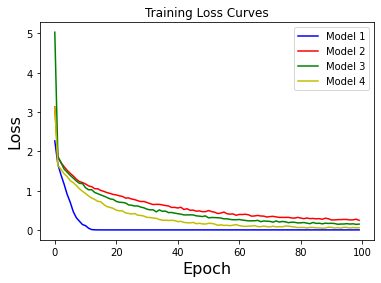

In [ ]:
plt.title('Training Loss Curves')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses1[:],'b')
plt.plot(train_losses2[:],'r')
plt.plot(train_losses3[:],'g')
plt.plot(train_losses4[:],'y')
plt.legend(['Model 1','Model 2','Model 3','Model 4'])
plt.show()

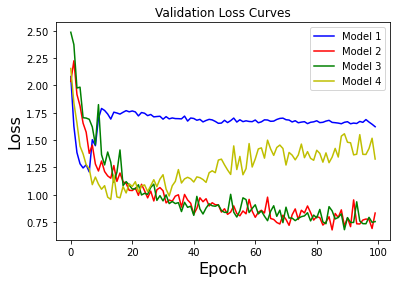

In [ ]:
plt.title('Validation Loss Curves')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(valid_losses1[:],'b')
plt.plot(valid_losses2[:],'r')
plt.plot(valid_losses3[:],'g')
plt.plot(valid_losses4[:],'y')
plt.legend(['Model 1','Model 2','Model 3','Model 4'])
plt.show()

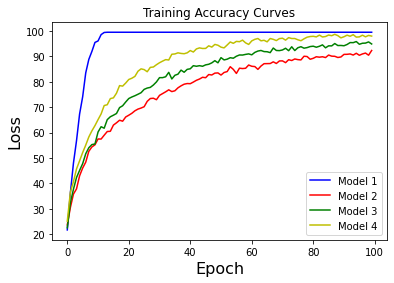

In [ ]:
plt.title('Training Accuracy Curves')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_acc1[:],'b')
plt.plot(train_acc2[:],'r')
plt.plot(train_acc3[:],'g')
plt.plot(train_acc4[:],'y')
plt.legend(['Model 1','Model 2','Model 3','Model 4'])
plt.show()

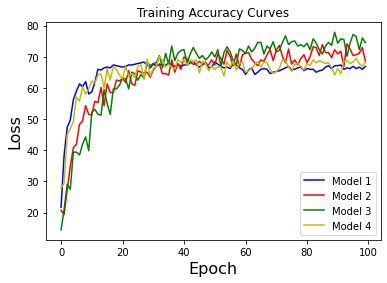

In [ ]:
plt.title('Training Accuracy Curves')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(valid_accu1[:],'b')
plt.plot(valid_accu2[:],'r')
plt.plot(valid_accu3[:],'g')
plt.plot(valid_accu4[:],'y')
plt.legend(['Model 1','Model 2','Model 3','Model 4'])
plt.show()

##References
https://towardsdatascience.com/speech-emotion-recognition-using-ravdess-audio-dataset-ce19d162690